Hannah's notebook to mess around with GCNs for lorenz. WORK IN PROGRESS. (My computer broke so I have to use the computer lab and save all my incremental changes somewhere.)

### imports


In [2]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError
from spektral.layers import GCNConv, GlobalSumPool
from spektral.models import GCN
from spektral.data import MixedLoader
from lorenz import lorenzDataset, plot_with_predictions

2022-11-13 23:16:39.611927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### prepare data


In [3]:
DEFAULT_TIME_RESOLUTION = 0.01

In [4]:
dataset = lorenzDataset(
    n_samples=100,
    input_steps=2 / DEFAULT_TIME_RESOLUTION,  # 2 days
    output_delay=1 / DEFAULT_TIME_RESOLUTION,  # 1 day
    output_steps=1,
    min_buffer=10,
    rand_buffer=False,
    K=36,
    F=8,
    c=10,
    b=10,
    h=1,
    coupled=True,
    time_resolution=DEFAULT_TIME_RESOLUTION,
    seed=42)

In [5]:
# inspect dataset
print(dataset)
print(dataset[0])

lorenzDataset(n_graphs=100)
Graph(n_nodes=36, n_node_features=400, n_edge_features=None, n_labels=1)


In [6]:
# split test/train data
# we can't use the keras split_dataset() function here because our Dataset
# class is incompatible
# we also cannot shuffle our data
train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]

train_loader = MixedLoader(dataset=train, batch_size=32)
val_loader = MixedLoader(dataset=val, batch_size=32)
test_loader = MixedLoader(dataset=test, batch_size=32)

In [7]:
# normalize the data using the training set's mean and stdev
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)

X1_mean 2.3532638213471277
X1_std 3.535734326547777
X2_mean 0.08281011593310098
X2_std 0.25753561822593996


In [8]:
# check that the normalization was successful, i.e. the train data should have
# a mean of exactly 0 and a stdev of exactly 1; val and test should have means
# near 0 and stdevs near 1
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('statistics for train set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = val.get_mean_std()
print('\nstatistics for val set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = test.get_mean_std()
print('\nstatistics for test set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)


statistics for train set
X1_mean -1.4922912467456263e-16
X1_std 1.0000000000000007
X2_mean 1.3083009102884384e-16
X2_std 1.0

statistics for val set
X1_mean 0.018235643713223983
X1_std 0.9994011846700579
X2_mean 0.01232221800288439
X2_std 0.9513997390755068

statistics for test set
X1_mean 0.009475998568648232
X1_std 1.0083518728950136
X2_mean 0.0015209229146075352
X2_std 0.946383112256971


#### inspect our data

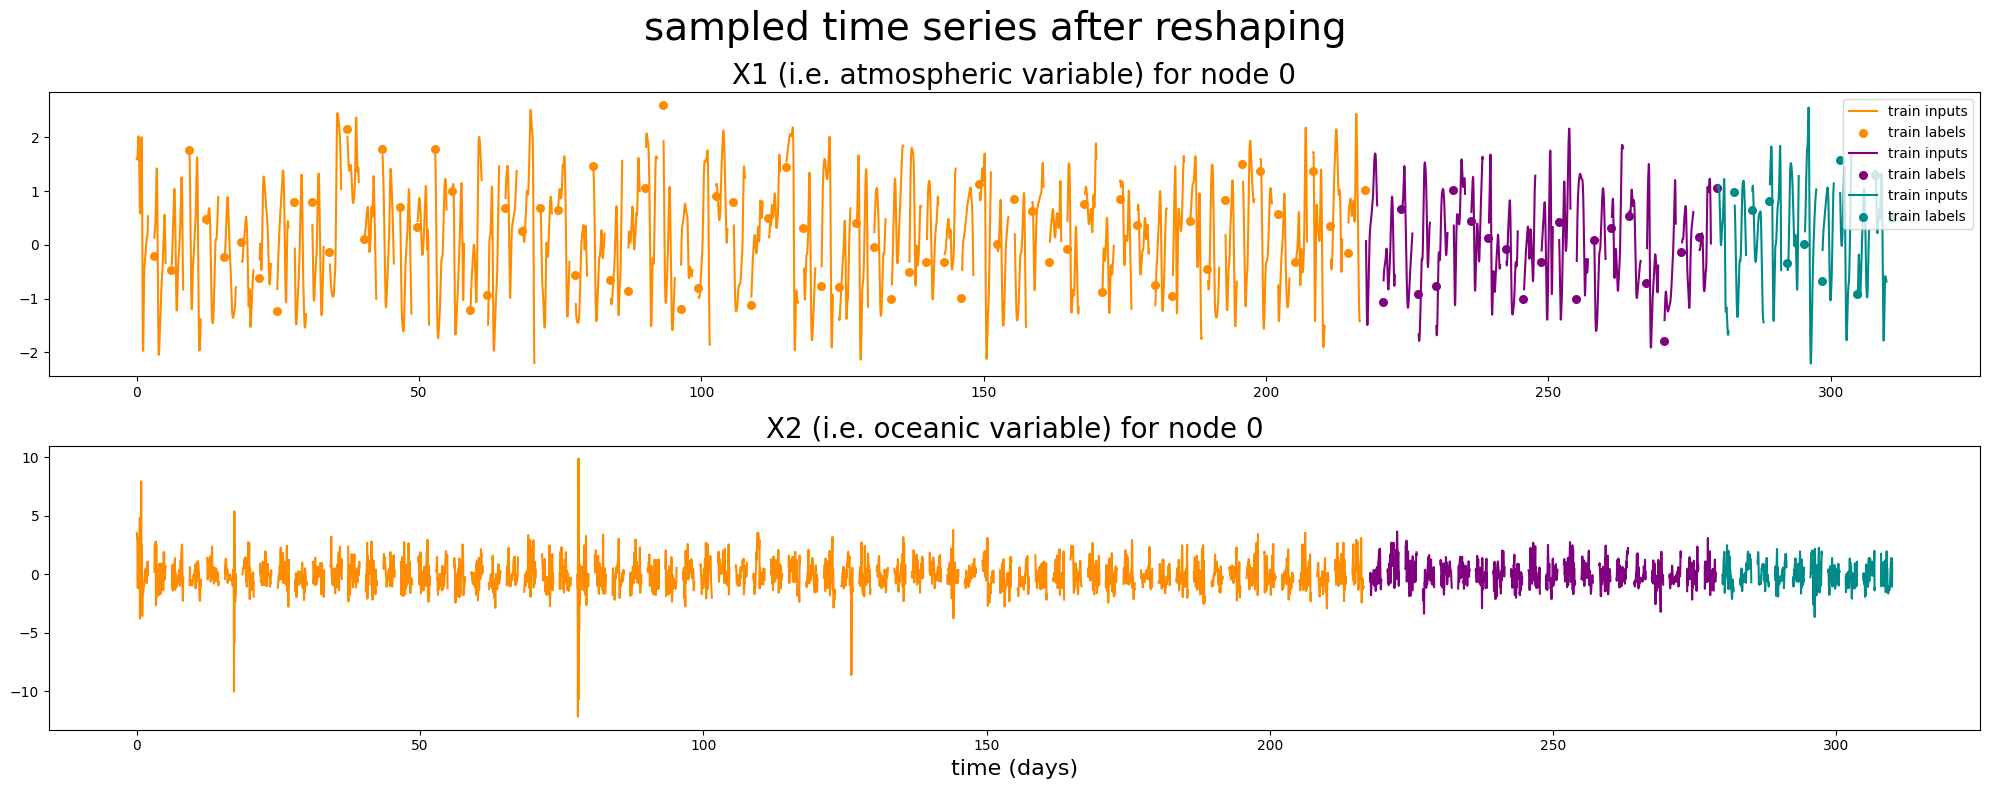

In [9]:
colors = ["darkorange", "purple", "darkcyan"]
node = 0

# set up plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))

fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
              size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

# plot train, val, and test data
fig, (ax0, ax1) = train.plot(node,
                             fig,
                             ax0,
                             ax1,
                             data_type='train',
                             color=colors[0])
fig, (ax0, ax1) = val.plot(node,
                           fig,
                           ax0,
                           ax1,
                           data_type='val',
                           color=colors[1])
fig, (ax0, ax1) = test.plot(node,
                            fig,
                            ax0,
                            ax1,
                            data_type='test',
                            color=colors[2])

# create legend
ax0.legend()
ax0.legend(handles=ax0.get_legend().legendHandles[0:6])
leg = ax0.get_legend()
[
    leg.legendHandles[i].set_color(colors[i // 2])
    for i in range(len(leg.legendHandles))
]

plt.tight_layout()
plt.show()

### out-of-the-box GCN

#### sanity check: initial error is reasonable

our final layer is a linear function. therefore, for the first epoch, when all our weights are initialized randomly and we set the regularization to 0, we would expect the error to be: ???

In [81]:
sanity_check_model1 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
sanity_check_model1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[MeanSquaredError(), RootMeanSquaredError()])
history = sanity_check_model1.fit(train_loader.load(),
                                  steps_per_epoch=train_loader.steps_per_epoch,
                                  epochs=10)


Epoch 1/10
3/3 [==============================] - 1s 11ms/step - loss: 65.1189 - mean_squared_error: 65.1189 - root_mean_squared_error: 8.0696
Epoch 2/10
3/3 [==============================] - 0s 7ms/step - loss: 31.9229 - mean_squared_error: 31.9229 - root_mean_squared_error: 5.6500
Epoch 3/10
3/3 [==============================] - 0s 8ms/step - loss: 14.1708 - mean_squared_error: 14.1708 - root_mean_squared_error: 3.7644
Epoch 4/10
3/3 [==============================] - 0s 10ms/step - loss: 8.1813 - mean_squared_error: 8.1813 - root_mean_squared_error: 2.8603
Epoch 5/10
3/3 [==============================] - 0s 9ms/step - loss: 7.9479 - mean_squared_error: 7.9479 - root_mean_squared_error: 2.8192
Epoch 6/10
3/3 [==============================] - 0s 9ms/step - loss: 7.0763 - mean_squared_error: 7.0763 - root_mean_squared_error: 2.6601
Epoch 7/10
3/3 [==============================] - 0s 6ms/step - loss: 6.5785 - mean_squared_error: 6.5785 - root_mean_squared_error: 2.5649
Epoch 8/10
3

/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


3/3 [==============================] - 0s 6ms/step - loss: 3.7289 - mean_squared_error: 3.7289 - root_mean_squared_error: 1.9310


#### sanity check: increasing regularization causes increasing loss

regularization reduces the amount of overfitting, thus increasing the loss on the training set

In [84]:
sanity_check_model2 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0.5,
    l2_reg=5e-4)
sanity_check_model2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[MeanSquaredError(), RootMeanSquaredError()])
history = sanity_check_model2.fit(train_loader.load(),
                                  steps_per_epoch=train_loader.steps_per_epoch,
                                  epochs=10)


Epoch 1/10
3/3 [==============================] - 1s 11ms/step - loss: 69.2231 - mean_squared_error: 69.1937 - root_mean_squared_error: 8.3183
Epoch 2/10
3/3 [==============================] - 0s 7ms/step - loss: 66.1276 - mean_squared_error: 66.0983 - root_mean_squared_error: 8.1301
Epoch 3/10
3/3 [==============================] - 0s 8ms/step - loss: 62.6881 - mean_squared_error: 62.6589 - root_mean_squared_error: 7.9157
Epoch 4/10
3/3 [==============================] - 0s 9ms/step - loss: 53.2993 - mean_squared_error: 53.2702 - root_mean_squared_error: 7.2986
Epoch 5/10
3/3 [==============================] - 0s 6ms/step - loss: 51.5947 - mean_squared_error: 51.5657 - root_mean_squared_error: 7.1809
Epoch 6/10
3/3 [==============================] - 0s 6ms/step - loss: 50.0368 - mean_squared_error: 50.0080 - root_mean_squared_error: 7.0716
Epoch 7/10
3/3 [==============================] - 0s 8ms/step - loss: 47.0048 - mean_squared_error: 46.9762 - root_mean_squared_error: 6.8539
Epoch

yep, the error with an L2 regularization of 5e-4 is higher than the error when the L2 regularzation was 0. 

#### sanity check 3: model can overfit

using 20 samples and setting regularization to 0, we want to make sure we can actually get to 0 error. 

(we also set dropout to 0 since dropout is supposed to help avoid overfitting.)

In [91]:
overfit_sample = train[:50]
overfit_loader = MixedLoader(dataset=overfit_sample, batch_size=20)

sanity_check_model3 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
sanity_check_model3.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = sanity_check_model3.fit(
    overfit_loader.load(),
    steps_per_epoch=overfit_loader.steps_per_epoch,
    epochs=2000)


Epoch 1/5000
3/3 [==============================] - 1s 3ms/step - loss: 45.1253 - mean_squared_error: 45.1253 - root_mean_squared_error: 6.7175
Epoch 2/5000
3/3 [==============================] - 0s 4ms/step - loss: 18.0420 - mean_squared_error: 18.0420 - root_mean_squared_error: 4.2476
Epoch 3/5000
3/3 [==============================] - 0s 3ms/step - loss: 13.8762 - mean_squared_error: 13.8762 - root_mean_squared_error: 3.7251
Epoch 4/5000
3/3 [==============================] - 0s 4ms/step - loss: 9.8330 - mean_squared_error: 9.8330 - root_mean_squared_error: 3.1358
Epoch 5/5000
3/3 [==============================] - 0s 4ms/step - loss: 7.9870 - mean_squared_error: 7.9870 - root_mean_squared_error: 2.8261
Epoch 6/5000
3/3 [==============================] - 0s 5ms/step - loss: 7.7072 - mean_squared_error: 7.7072 - root_mean_squared_error: 2.7762
Epoch 7/5000
3/3 [==============================] - 0s 4ms/step - loss: 6.0768 - mean_squared_error: 6.0768 - root_mean_squared_error: 2.4651


KeyboardInterrupt: 

the MSE got down to around 0.2ish by epoch 1000; however, after that, it fluctuated between  0.2 to 1 ish and didn't seem to ever get under 0.2. 

Is this good enough?

### train GCN model

In [36]:
GCN_model = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None, # we want regression, i.e. a linear function
    use_bias=False,
    dropout_rate=0.5,
    l2_reg=2.5e-4)
GCN_model.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = GCN_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=200)

Epoch 1/200
3/3 [==============================] - 1s 3ms/step - loss: 66.4621
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 60.4770
Epoch 3/200
3/3 [==============================] - 0s 3ms/step - loss: 55.7428
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 58.9014
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 46.6058
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 46.2462
Epoch 7/200
3/3 [==============================] - 0s 3ms/step - loss: 43.9997
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 40.9963
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 36.1734
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 36.9519
Epoch 11/200
3/3 [==============================] - 0s 4ms/step - loss: 34.6007
Epoch 12/200
3/3 [==============================] - 0s 3ms/step - loss: 30.9809
Epoch 13/200
3/3 [==============================]

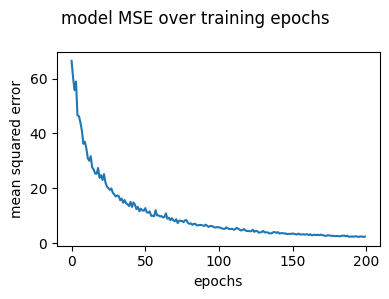

In [37]:
# print(type(history.history))
# print(history.history)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(history.history['loss'])
ax.set_ylabel('mean squared error')
ax.set_xlabel('epochs')
fig.suptitle('model MSE over training epochs')
plt.tight_layout()
plt.show()

### GCN predictions

visualize predictions on the training set

3/3 [==============================] - 0s 4ms/step
(70, 36, 1)


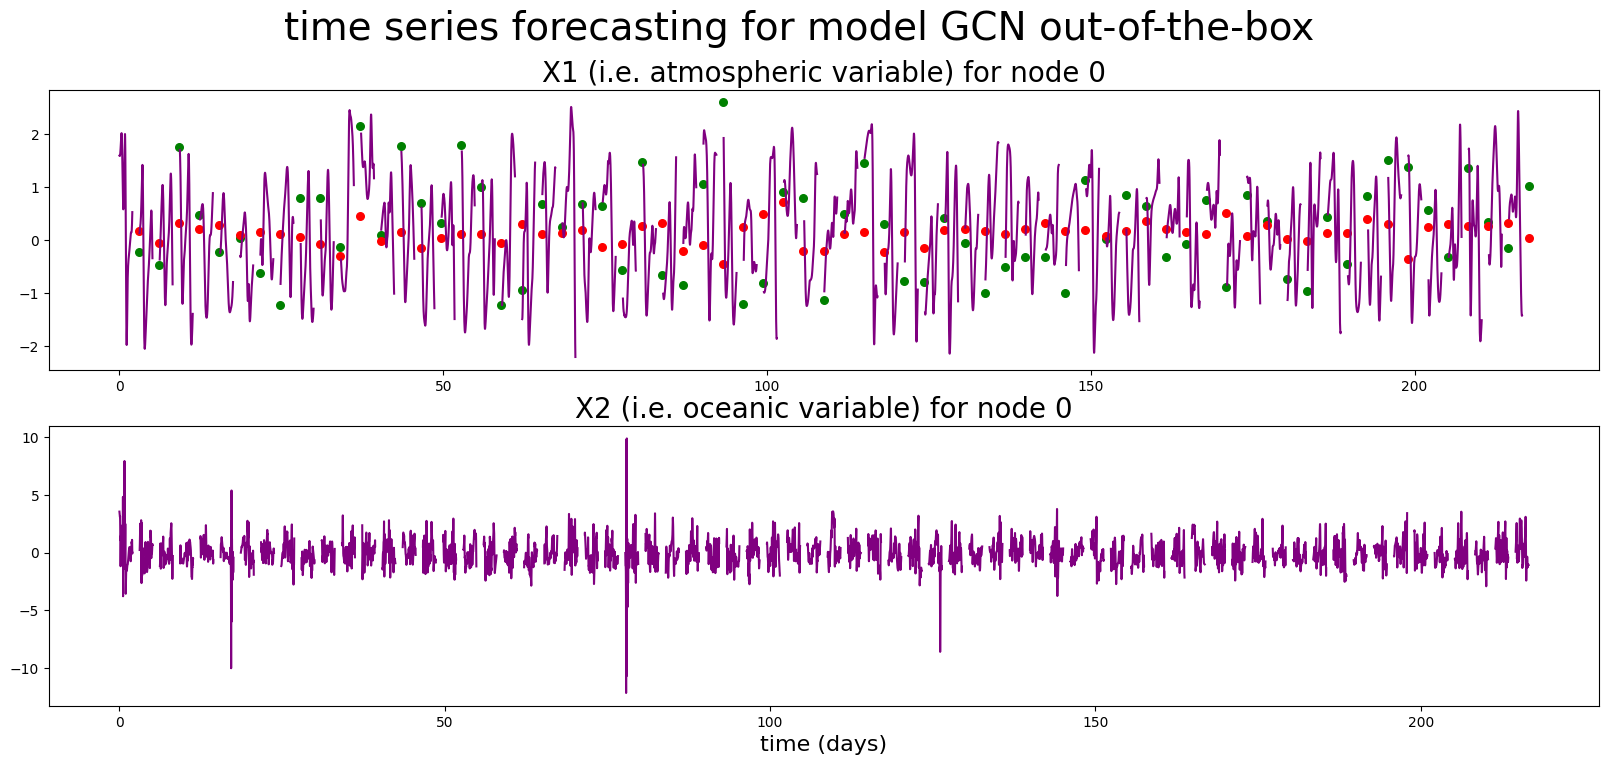

In [38]:
fig, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                        graph_dataset=train,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='GCN out-of-the-box')
plt.show()

these predictions are... pretty bad, lol

also, why are we seeing np.shuffle() being called? where is that occurring?

visualize predictions for the validation set

1/1 [==============================] - 0s 26ms/step


/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


(20, 36, 1)


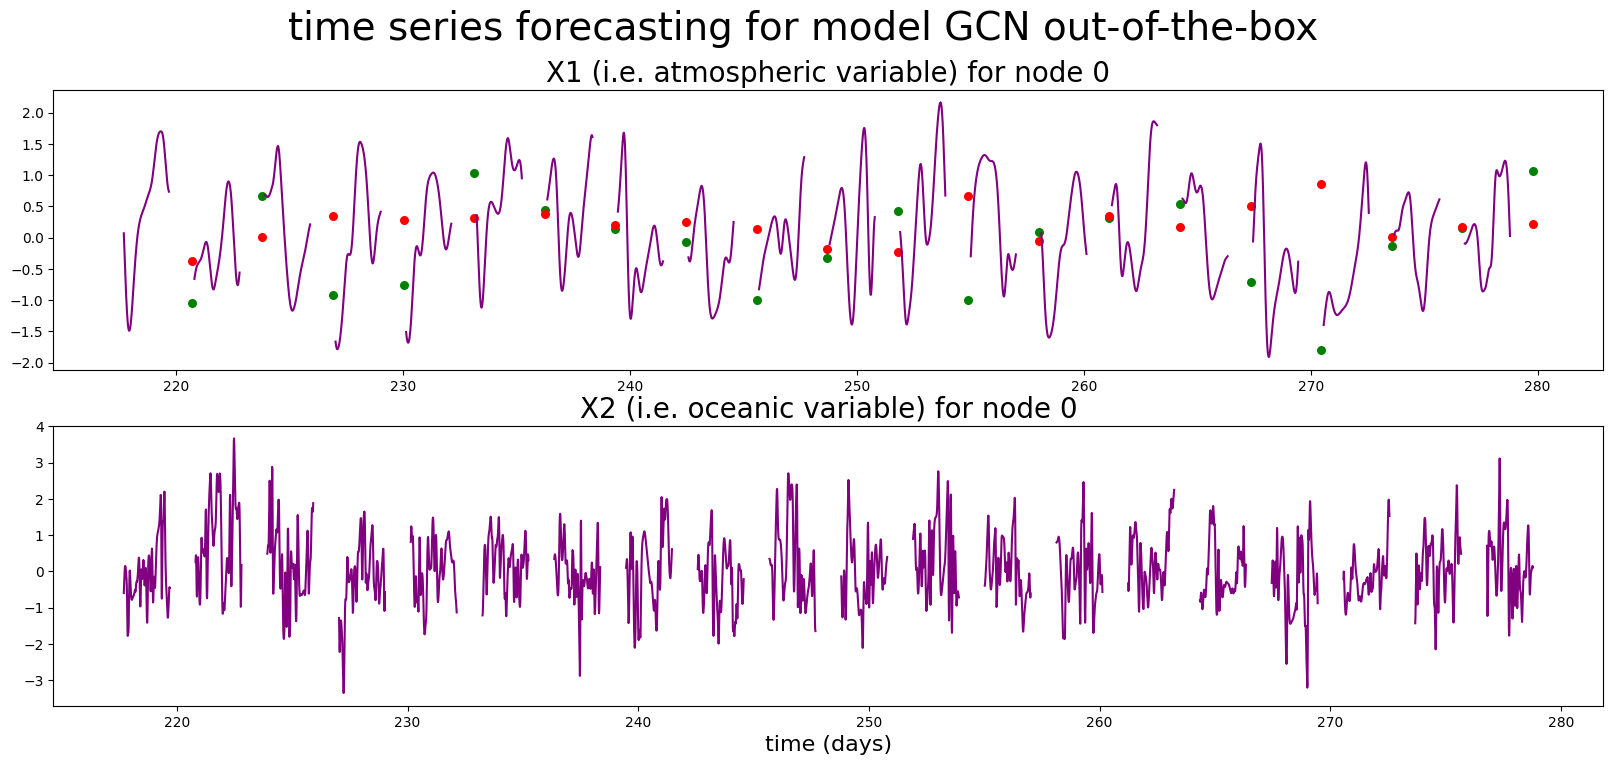

In [39]:
fig, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                        graph_dataset=val,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='GCN out-of-the-box')
plt.show()

In [41]:
# TODO: try some different training parameters 
# TODO: try this with continuous windowing and compare this with LSTM ? 

## custom GCN

### define custom model

In [42]:
class customGCN(Model):
    # TODO: something is going super wrong here
    def __init__(self, n_hidden, output_dim, dropout=0.5):
        super().__init__()
        self.gcn0 = GCNConv(n_hidden, activation='relu')
        self.gcn1 = GCNConv(n_hidden, activation='relu')
        self.pool = GlobalSumPool()
        self.dropout0 = Dropout(dropout)
        self.dropout1 = Dropout(dropout)
        self.dense = Dense(units=output_dim,
                           activation=None)  # linear regression layer

    def call(self, inputs):
        # print(type(inputs))
        # print(len(inputs))
        # print('\n\n')
        # print(inputs)
        x, a = inputs
        x = self.dropout0(x)
        x = self.gcn0([x, a])
        x = self.dropout1(x)
        x = self.gcn1([x, a])
        x = self.pool(x)
        out = self.dense(x)
        return out

In [44]:
custom_model = customGCN(n_hidden=32,
                         output_dim=dataset[0].y.shape[-1],
                         dropout=0.5)
custom_model.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = custom_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 5ms/step - loss: 8983.7988
Epoch 2/100
3/3 [==============================] - 0s 7ms/step - loss: 5424.3018
Epoch 3/100
3/3 [==============================] - 0s 7ms/step - loss: 5990.4600
Epoch 4/100
3/3 [==============================] - 0s 7ms/step - loss: 3833.9778
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 4214.7495
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 4581.6348
Epoch 7/100
3/3 [==============================] - 0s 7ms/step - loss: 3319.2415
Epoch 8/100
3/3 [==============================] - 0s 7ms/step - loss: 4123.9038
Epoch 9/100
3/3 [==============================] - 0s 7ms/step - loss: 2818.3496
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 2972.5000
Epoch 11/100
3/3 [==============================] - 0s 8ms/step - loss: 2518.0635
Epoch 12/100
3/3 [==============================] - 0s 7ms/step - loss: 2948.6892
Epoch 13/100
3/3 [=======